In [2]:
!pip install yfinance --upgrade --no-cache-dir

Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.26
    Uninstalling yfinance-0.2.26:
      Successfully uninstalled yfinance-0.2.26


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime
#Pacote PyWavelets
import pywt


>Importando o YFinance e sobrescrevendo os métodos do `pandas_datareader`

In [4]:
import yfinance as yf
yf.pdr_override()

# Obtendo os dados do mercado

>Baixando as cotações do Yahoo Finance para o Índice Bovespa, dolar e bitcoin


In [116]:
ibov = web.get_data_yahoo('^BVSP')
dji = web.get_data_yahoo('^DJI')
dolar = web.get_data_yahoo("USDBRL=X")
SeP500 = web.get_data_yahoo("^GSPC")
Nasdaq = web.get_data_yahoo("^IXIC")
SSE50 = web.get_data_yahoo("000016.SS")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [117]:
df_ = pd.concat([ibov["Open"], dji["Open"], SeP500["Open"], Nasdaq["Open"]], #dolar["Open"], bitcoin["Open"]
                axis=1, join='outer')
df_.columns = ["ibov", "dji", "SeP500", "Nasdaq"]#, "dolar", "bitcoin"]
df_o = df_['2012-02-01':'2023-08-04']
df_o.tail()


df_2 = pd.concat([ibov["Open"], dji["Open"], SeP500["Open"], Nasdaq["Open"], dolar["Open"], SSE50["Open"]],
                axis=1, join='outer')
df_2.columns = ["ibov", "dji", "SeP500", "Nasdaq", "dolar", "SSE50"]
df_2 = df_2['2012-02-01':'2023-08-04']

<AxesSubplot:>

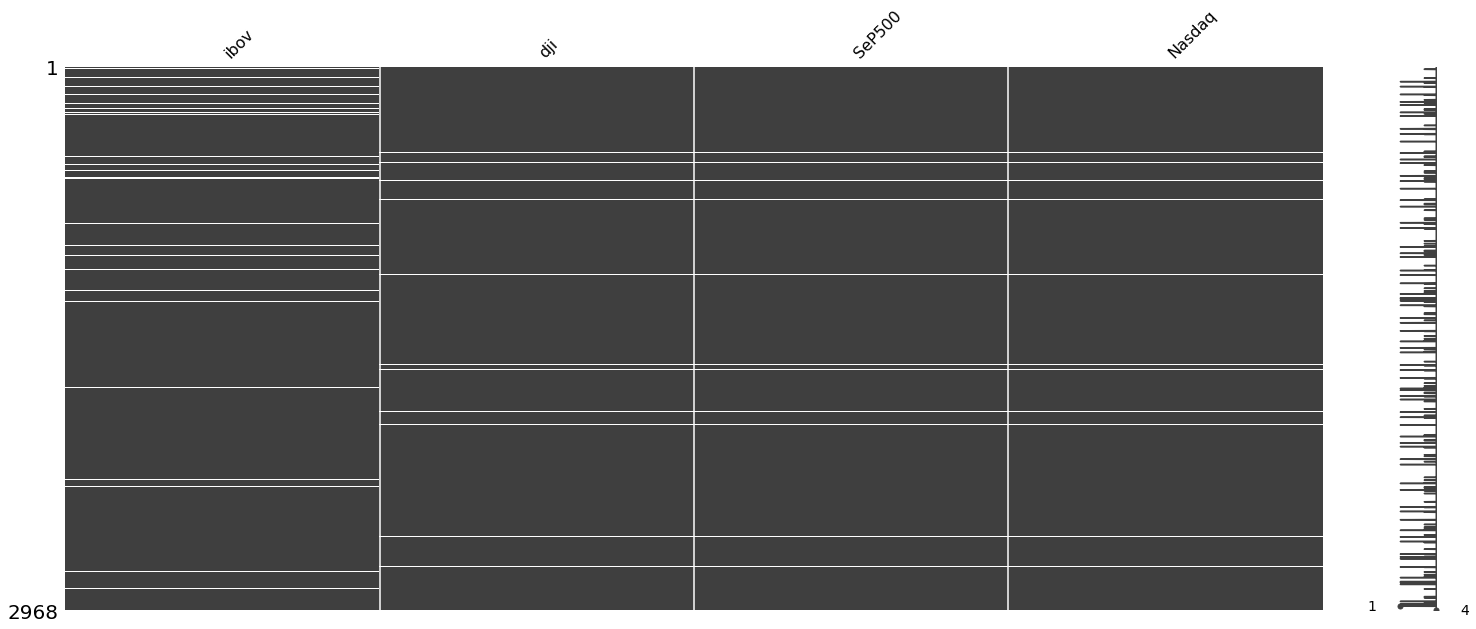

In [118]:
import missingno as msno
# Visualize missing values as a matrix
msno.matrix(df_o)

In [119]:
df_o.ibov = df_o.ibov.interpolate(method="backfill")
df_o.dji = df_o.dji.interpolate(method="backfill")
df_o.SeP500 = df_o.SeP500.interpolate(method="backfill")
df_o.Nasdaq = df_o.Nasdaq.interpolate(method="backfill")

C:\Users\matheus.mori\AppData\Local\Temp\ipykernel_23440\875223617.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\matheus.mori\AppData\Local\Temp\ipykernel_23440\875223617.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\matheus.mori\AppData\Local\Temp\ipykernel_23440\875223617.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

<AxesSubplot:>

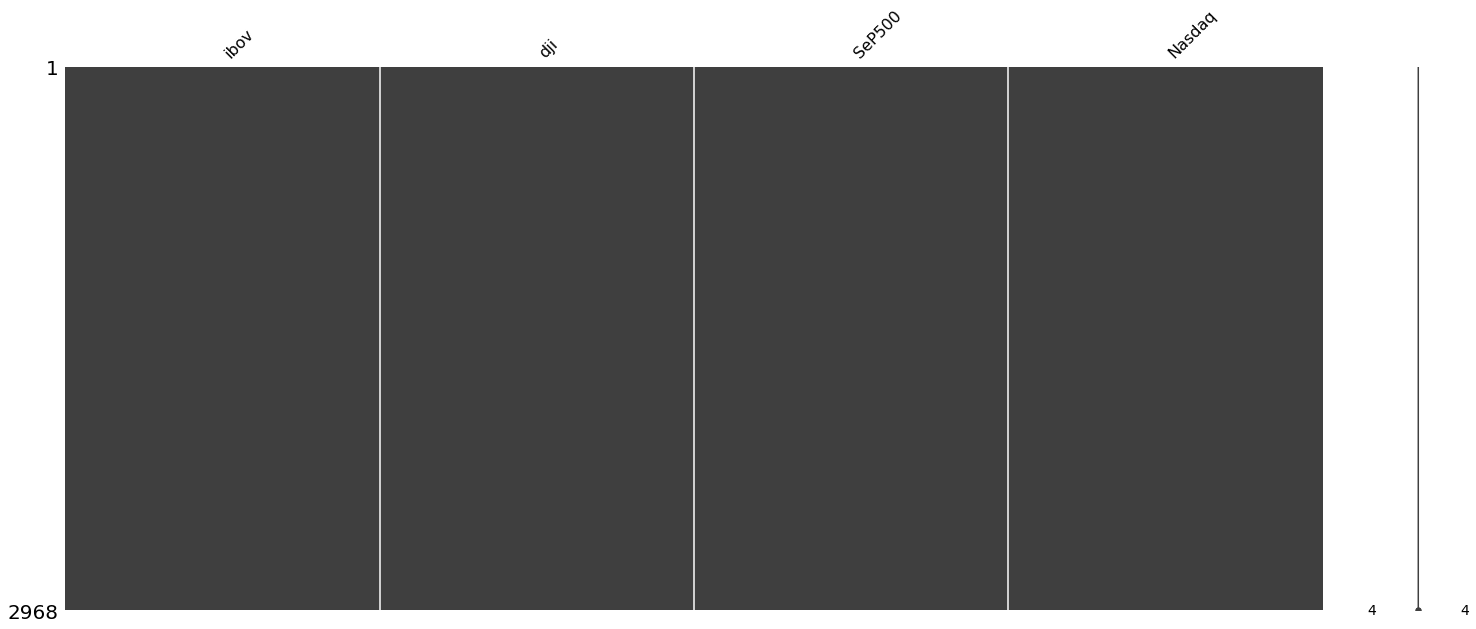

In [120]:
msno.matrix(df_o)

In [121]:
df = df_o.copy()

>Plotando o gráfico com o preços de fechamento do Índice Bovespa

In [122]:
import plotly.express as px

fig = px.line(df, y=df.columns, title='custom tick labels')
fig.update_xaxes(
    dtick="M1")
fig.show()

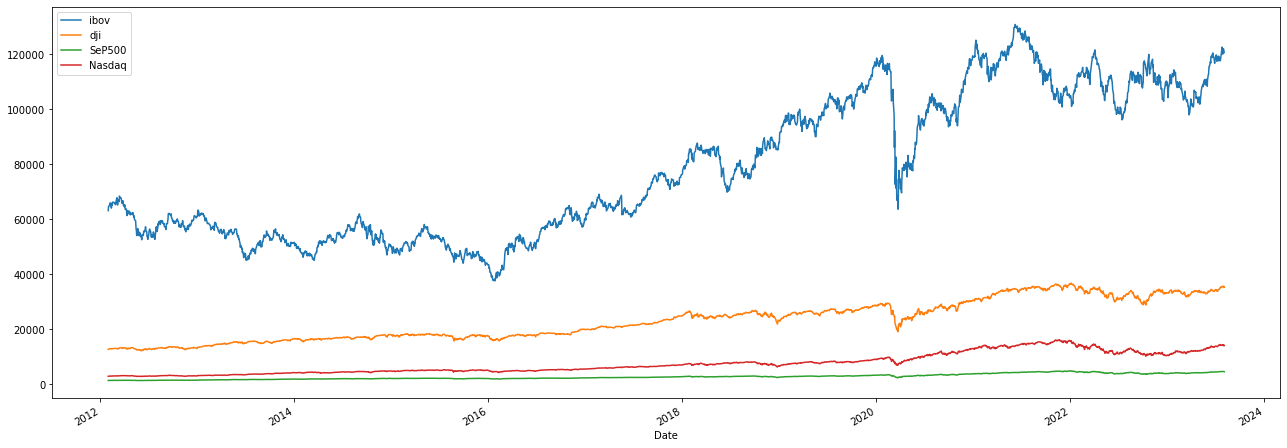

In [123]:
df.plot(figsize=(22,8));

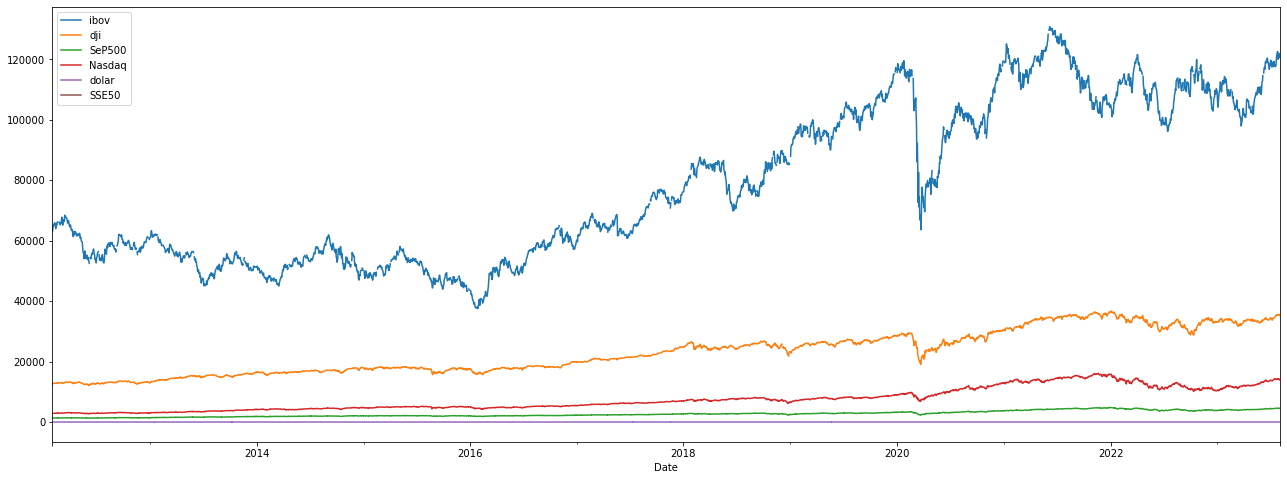

In [125]:
df_2.plot(figsize=(22,8));

In [126]:
df_2.SSE50

Date
2012-02-01            NaN
2012-02-02            NaN
2012-02-03            NaN
2012-02-06            NaN
2012-02-07            NaN
                 ...     
2023-07-31            NaN
2023-08-01            NaN
2023-08-02            NaN
2023-08-03            NaN
2023-08-04    2664.586426
Name: SSE50, Length: 3003, dtype: float64

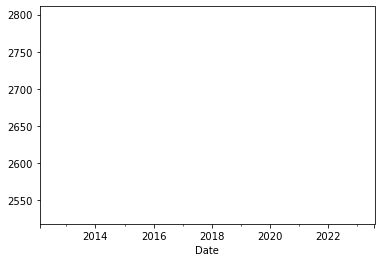

In [127]:
df_2.SSE50.plot();

# Tratamento dos dados

# Aplicação de wavelet

In [84]:
#Serie do Dólar
serie_d = dji.Close.loc['2012-02-01':'2023-08-04'].copy()

#Para evitar problemas de borda insere amostras adicionais a série
#mais detalhes: https://pywavelets.readthedocs.io/en/latest/ref/signal-extension-modes.html#ref-modes
amostras_pad = 200
serie_pad    = pywt.pad(serie_d, amostras_pad, 'symmetric')

#Obtém o ano inicial e final
ano_inicial = min(serie_d.index).year
ano_final   = max(serie_d.index).year
print(ano_inicial)
print(ano_final)

#Cria indices para mostrar no eixo x
anos = np.arange(ano_inicial, ano_final + 1, 1)
ia   = np.arange(0, len(serie_d), 242)
print(len(anos))
print(len(ia))

2012
2023
12
12


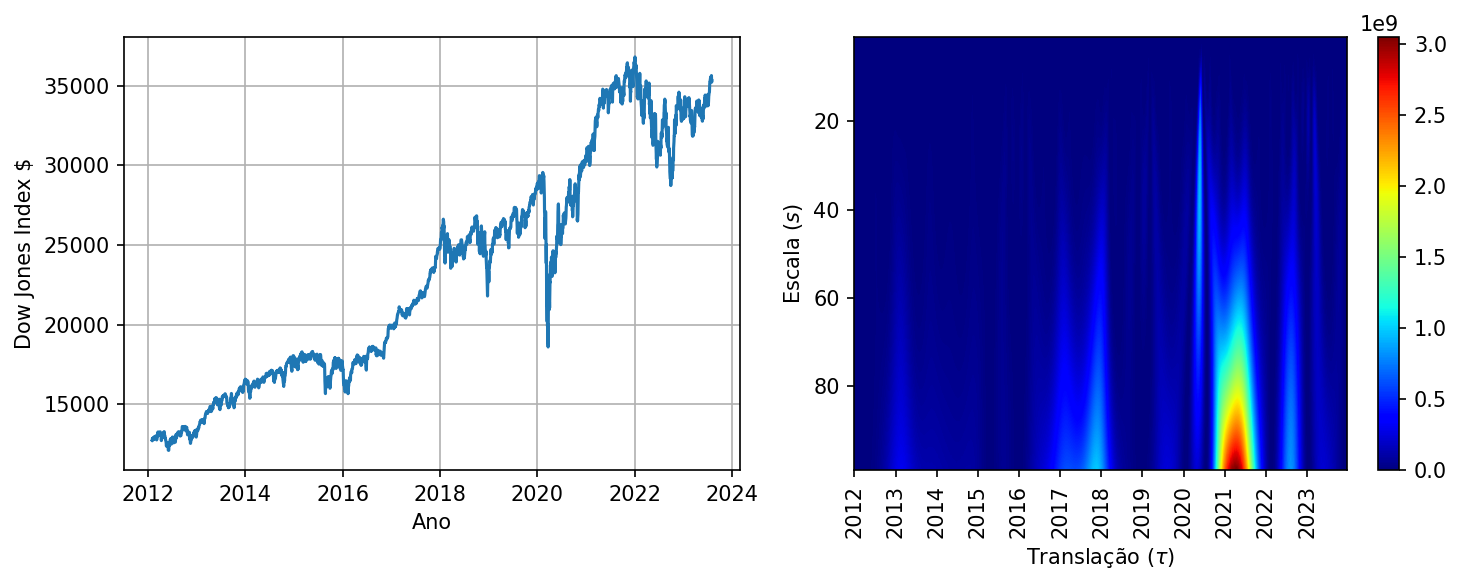

In [85]:

#Calcula o escalograma
wav  = 'gaus1'                     # Wavelet com 1 momento nulo
s    = np.arange(1, 100)           #Escalas utilizadas
coef, freqs = pywt.cwt(serie_pad, s, wav, method='fft') #coeficientes wavelets
coef_    = np.abs(coef)**2                #obtêm o Escalograma



#Trunca W devido a operação de inserção de amostras (padding)
coef_ = coef_[:, amostras_pad:-amostras_pad]

plt.figure(dpi=150, figsize=(10, 4))
plt.subplot(121)
plt.plot(serie_d)
plt.ylabel('Dow Jones Index $')
plt.xlabel('Ano')
#plt.xticks(ia, anos, rotation='vertical')
#plt.xlim([0, len(serie)])

plt.grid()
plt.subplot(122)
plt.imshow(coef_, extent=[0, len(serie_d), s[-1], s[0]], cmap='jet', aspect='auto', interpolation='spline16')
plt.xticks(ia, anos, rotation='vertical')
#plt.yticks(np.arange(0, len(s), 10))
plt.xlabel('Translação ($\\tau$)')
plt.ylabel('Escala ($s$)')
#plt.ylim([s[-1], s[0]])
#plt.xlim([0, len(serie)])
#for i in np.arange(1, int(len(s)/12)):
#  plt.plot(np.ones(len(serie)) * (i * 12), color='white', alpha=0.5)
plt.colorbar()
plt.tight_layout()
plt.show()

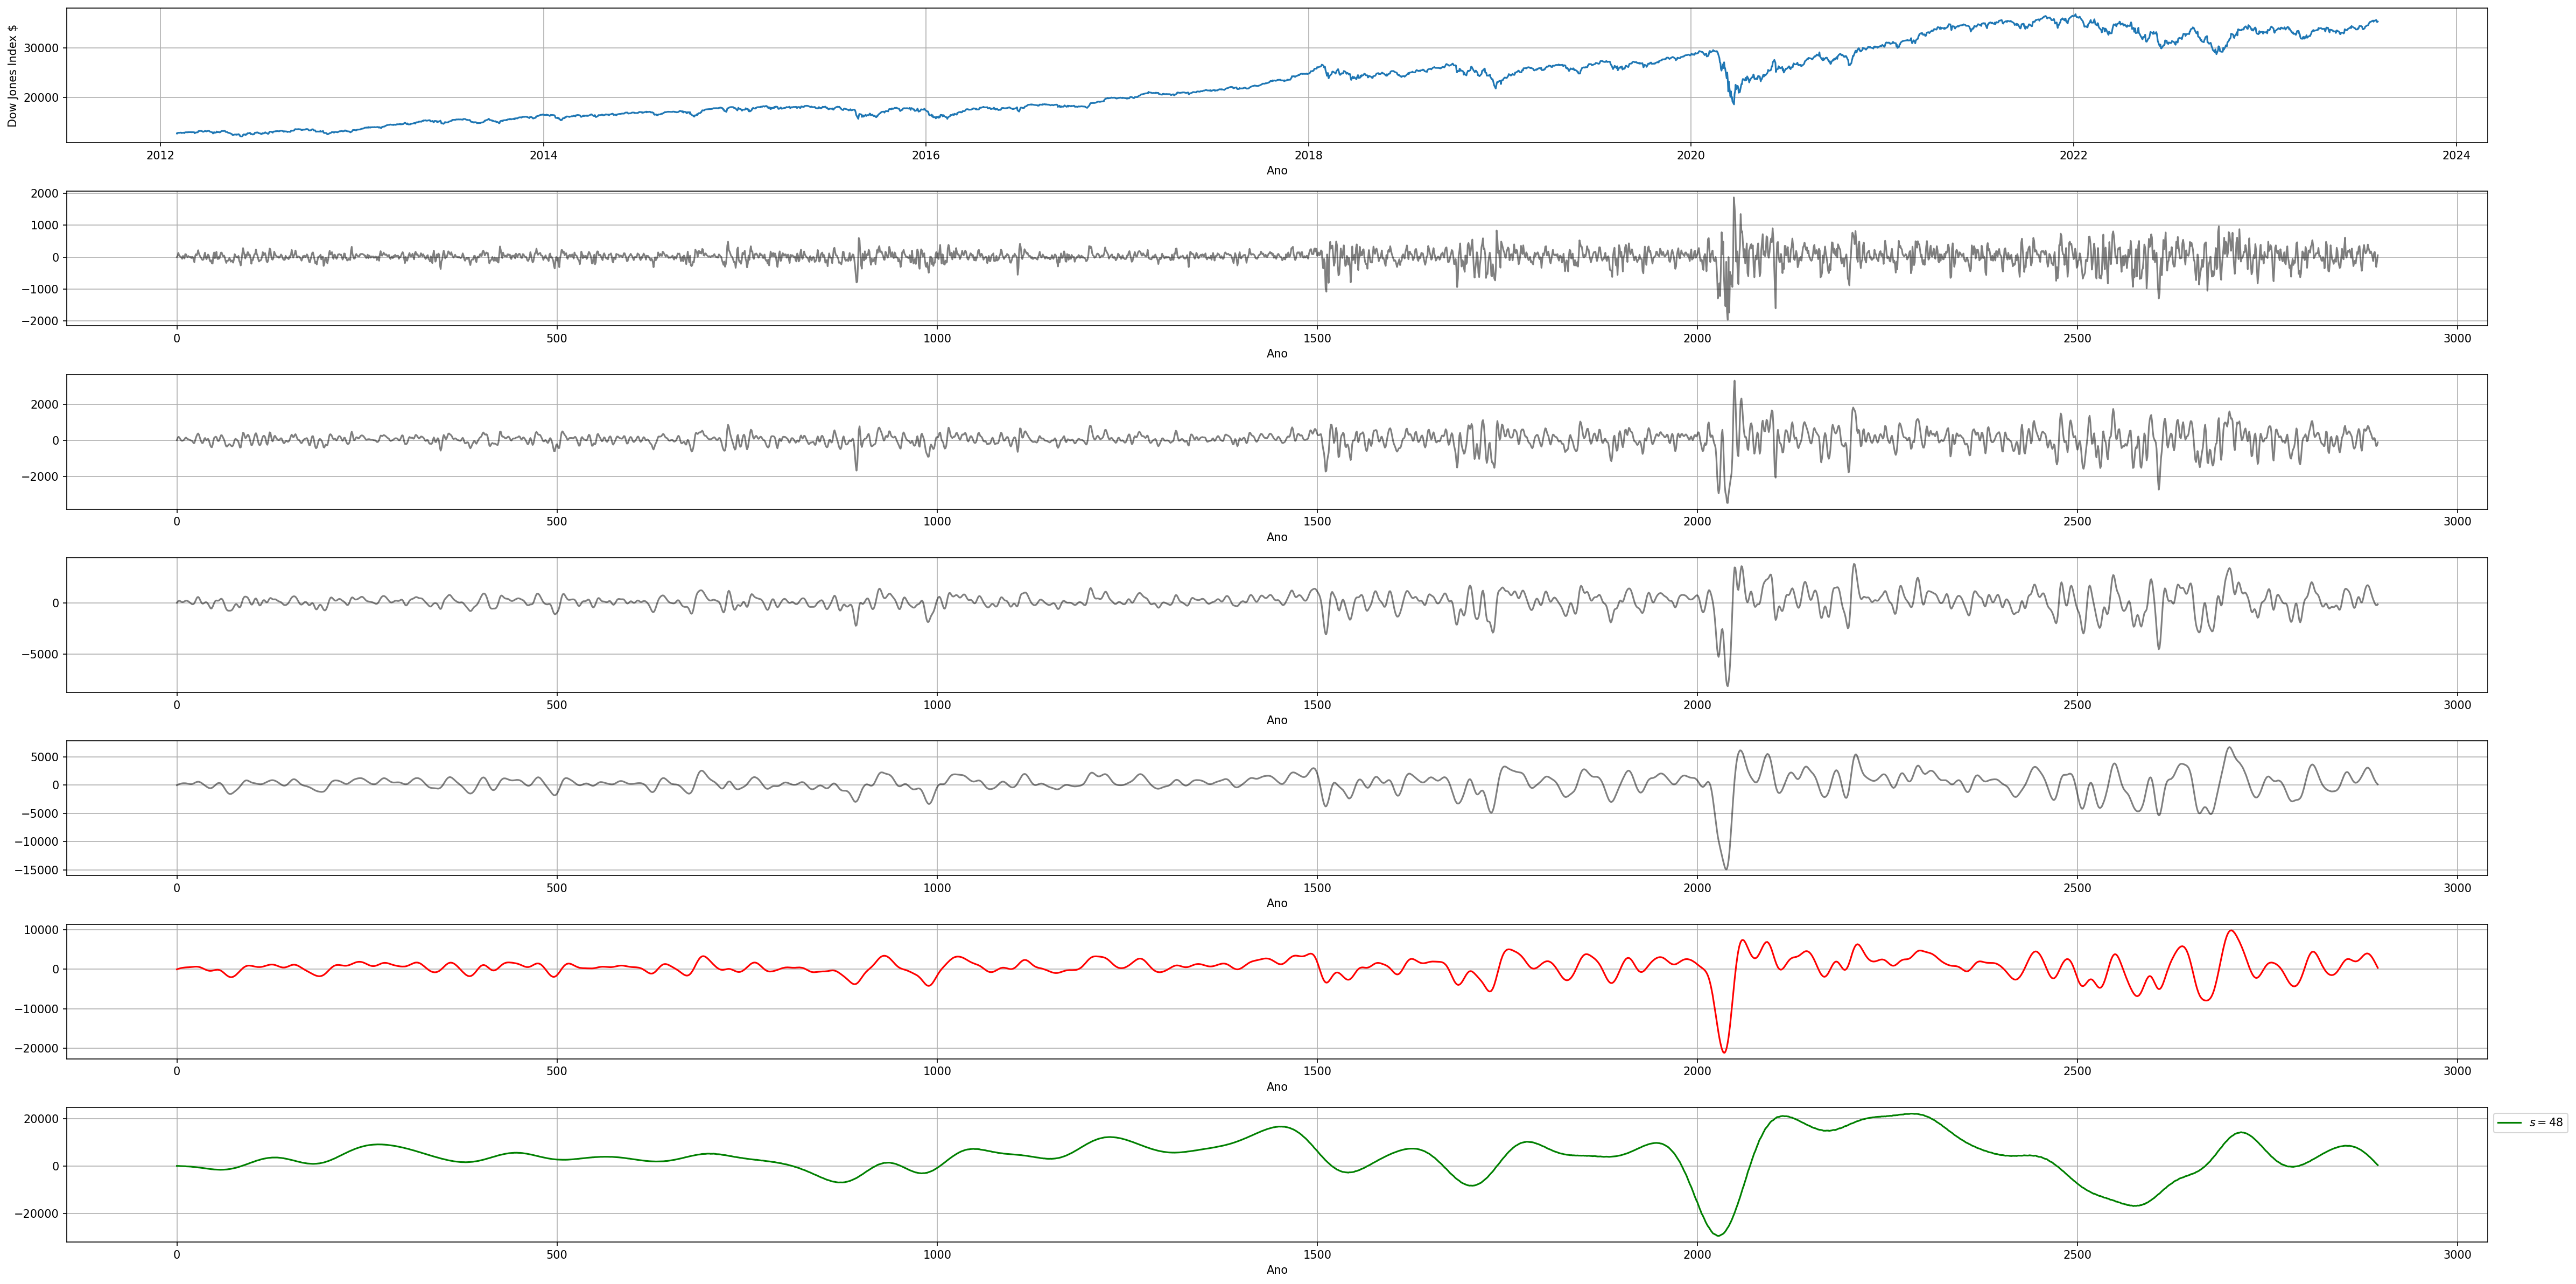

In [87]:
#Analisando alguns coeficientes wavelets

#Multiplica todos os coeficientes wavelets por (-1), por de acordo com Mallat
# (-1) derivada primeira será correspondente aos pontos de variação da função
C1 = -coef

#Coeficientes em algums escalas normalizados
Cs1  = C1[0,amostras_pad:-amostras_pad]
Cs2 = C1[1,amostras_pad:-amostras_pad]
Cs4 = C1[3,amostras_pad:-amostras_pad]
Cs8 = C1[7,amostras_pad:-amostras_pad]
Cs16 = C1[11,amostras_pad:-amostras_pad]
Cs24 = C1[23,amostras_pad:-amostras_pad]
Cs48 = C1[47,amostras_pad:-amostras_pad]

#Cs1  = Cs1/np.linalg.norm(Cs1, 1)
#Cs16 = Cs16/np.linalg.norm(Cs16, 1)
#Cs48 = Cs48/np.linalg.norm(Cs48, 1)

plt.figure(dpi=150, figsize=(32, 16))
plt.subplot(711)
plt.plot(serie_d)
plt.ylabel('Dow Jones Index $')
plt.xlabel('Ano')
#plt.xticks(ia, anos, rotation='vertical')
#plt.xlim([0, len(serie)])
plt.grid()

plt.subplot(712)
plt.plot(Cs1, label='$s=1$', color='k', alpha=0.5)
plt.xlabel('Ano')
plt.grid()

plt.subplot(713)
plt.plot(Cs2, label='$s=1$', color='k', alpha=0.5)
plt.xlabel('Ano')
plt.grid()

plt.subplot(714)
plt.plot(Cs4, label='$s=1$', color='k', alpha=0.5)
plt.xlabel('Ano')
plt.grid()

plt.subplot(715)
plt.plot(Cs8, label='$s=1$', color='k', alpha=0.5)
plt.xlabel('Ano')
plt.grid()


plt.subplot(716)
plt.plot(Cs16, label='$s=12$', color='r')
plt.xlabel('Ano')
plt.grid()


plt.subplot(717)
plt.plot(Cs48, label='$s=48$', color='g')
plt.xlabel('Ano')
plt.grid()


plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

## ibov

In [88]:
#Serie do Dólar
serie_ibov = ibov.Close.loc['2012-02-01':'2023-06-01'].copy()

#Para evitar problemas de borda insere amostras adicionais a série
#mais detalhes: https://pywavelets.readthedocs.io/en/latest/ref/signal-extension-modes.html#ref-modes
amostras_pad = 200
serie_pad    = pywt.pad(serie_ibov, amostras_pad, 'symmetric')

#Obtém o ano inicial e final
ano_inicial = min(serie_ibov.index).year
ano_final   = max(serie_ibov.index).year
print(ano_inicial)
print(ano_final)

#Cria indices para mostrar no eixo x
anos = np.arange(ano_inicial, ano_final + 1, 1)
ia   = np.arange(0, len(serie_ibov), 246)
print(len(anos))
print(len(ia))

2012
2023
12
12


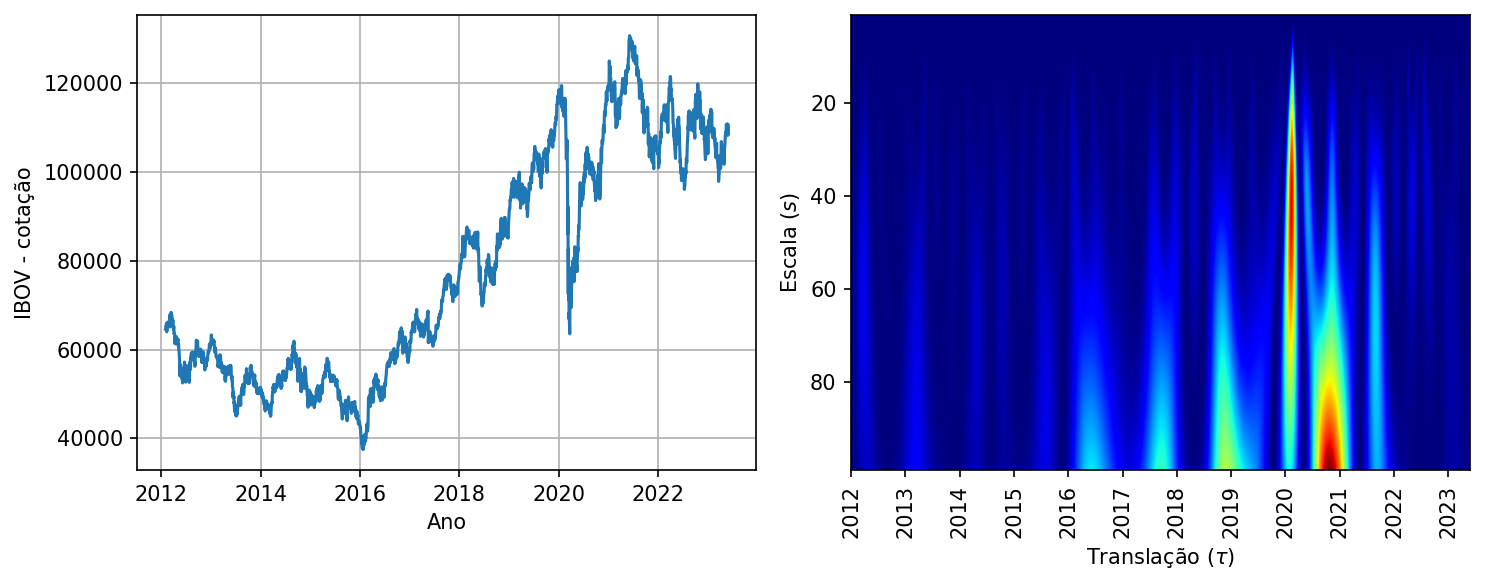

In [89]:

#Calcula o escalograma
wav  = 'gaus1'                     # Wavelet com 1 momento nulo
s    = np.arange(1, 100)           #Escalas utilizadas
coef, _ = pywt.cwt(serie_pad, s, wav, method='fft') #coeficientes wavelets
coef_W    = np.abs(coef)**2                #obtêm o Escalograma

#Trunca W devido a operação de inserção de amostras (padding)
coef_W = coef_W[:, amostras_pad:-amostras_pad]

plt.figure(dpi=150, figsize=(10, 4))
plt.subplot(121)
plt.plot(serie_ibov)
plt.ylabel('IBOV - cotação')
plt.xlabel('Ano')
#plt.xticks(ia, anos, rotation='vertical')
#plt.xlim([0, len(serie)])
plt.grid()
plt.subplot(122)
plt.imshow(coef_W, extent=[0, len(serie_ibov), s[-1], s[0]], cmap='jet', aspect='auto', interpolation='spline16')
plt.xticks(ia, anos, rotation='vertical')
#plt.yticks(np.arange(0, len(s), 10))
plt.xlabel('Translação ($\\tau$)')
plt.ylabel('Escala ($s$)')
#plt.ylim([s[-1], s[0]])
#plt.xlim([0, len(serie)])
#for i in np.arange(1, int(len(s)/12)):
#  plt.plot(np.ones(len(serie)) * (i * 12), color='white', alpha=0.5)
plt.tight_layout()
plt.show()

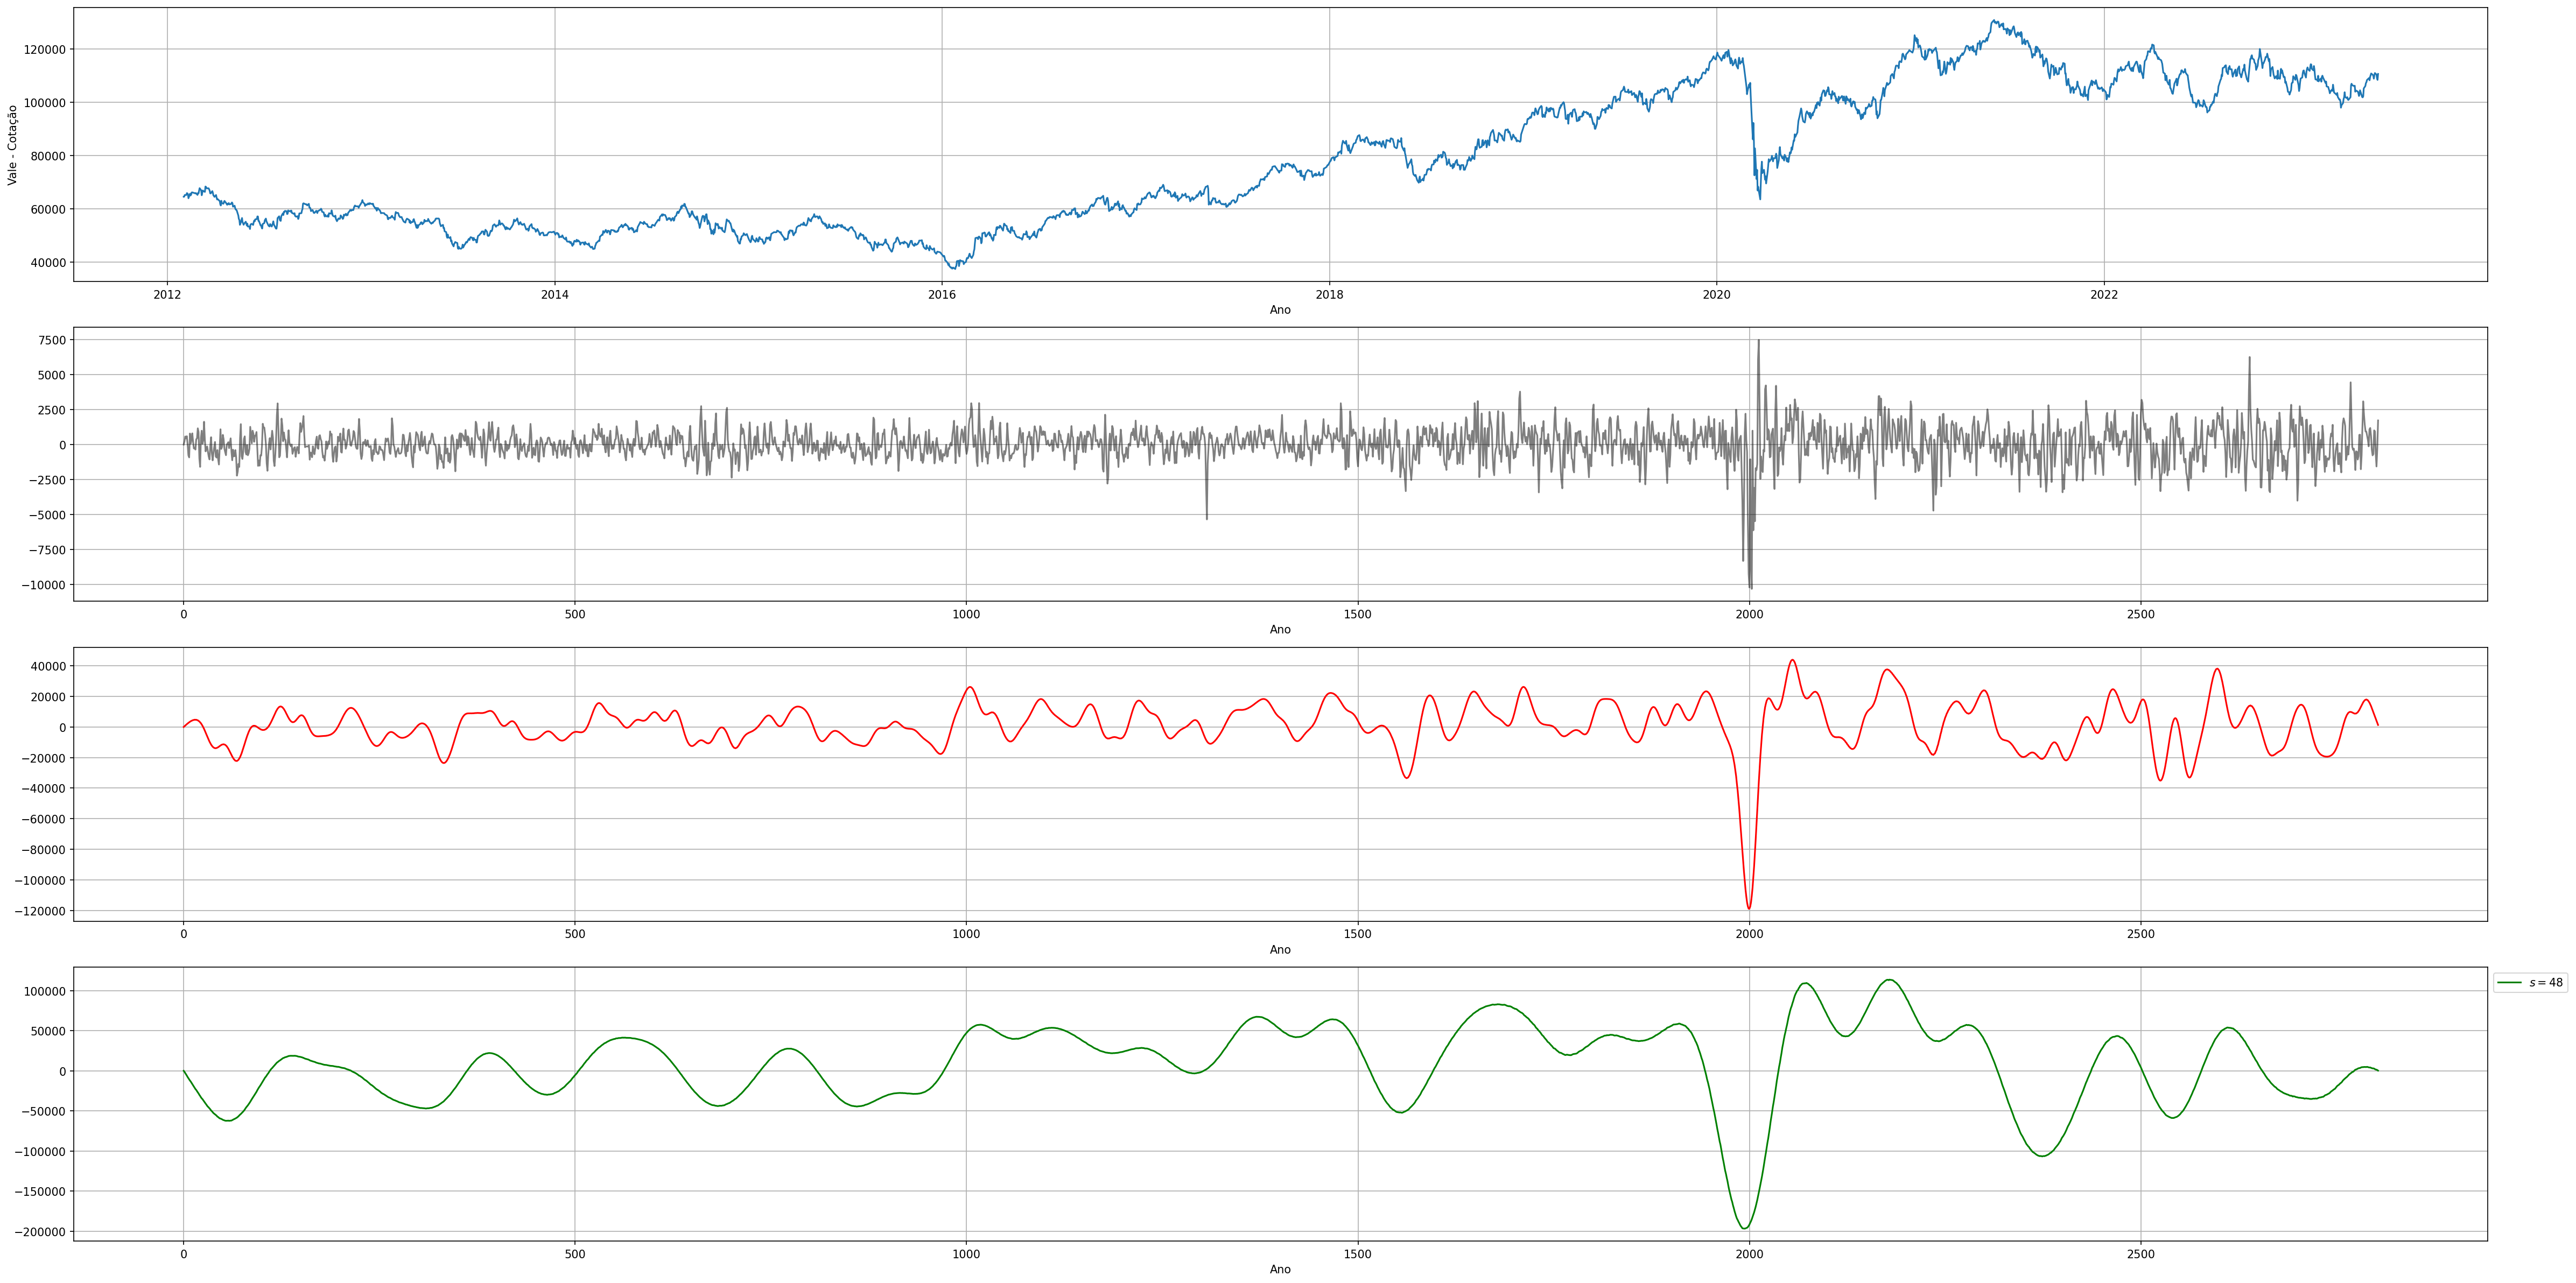

In [90]:
#Analisando alguns coeficientes wavelets

#Multiplica todos os coeficientes wavelets por (-1), por de acordo com Mallat
# (-1) derivada primeira será correspondente aos pontos de variação da função
C1 = -coef

#Coeficientes em algums escalas normalizados
Cs1  = C1[0,amostras_pad:-amostras_pad]
Cs2 = C1[1,amostras_pad:-amostras_pad]
Cs4 = C1[3,amostras_pad:-amostras_pad]
Cs8 = C1[7,amostras_pad:-amostras_pad]
Cs16 = C1[11,amostras_pad:-amostras_pad]
Cs24 = C1[23,amostras_pad:-amostras_pad]
Cs48 = C1[47,amostras_pad:-amostras_pad]

#Cs1  = Cs1/np.linalg.norm(Cs1, 1)
#Cs16 = Cs16/np.linalg.norm(Cs16, 1)
#Cs48 = Cs48/np.linalg.norm(Cs48, 1)

plt.figure(dpi=150, figsize=(32, 16))
plt.subplot(411)
plt.plot(serie_ibov)
plt.ylabel('Vale - Cotação')
plt.xlabel('Ano')
#plt.xticks(ia, anos, rotation='vertical')
#plt.xlim([0, len(serie)])
plt.grid()

plt.subplot(412)
plt.plot(Cs1, label='$s=1$', color='k', alpha=0.5)
plt.xlabel('Ano')
plt.grid()

plt.subplot(413)
plt.plot(Cs16, label='$s=12$', color='r')
plt.xlabel('Ano')
plt.grid()

plt.subplot(414)
plt.plot(Cs48, label='$s=48$', color='g')
plt.xlabel('Ano')
plt.grid()


plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

## Visualização 3D

In [91]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

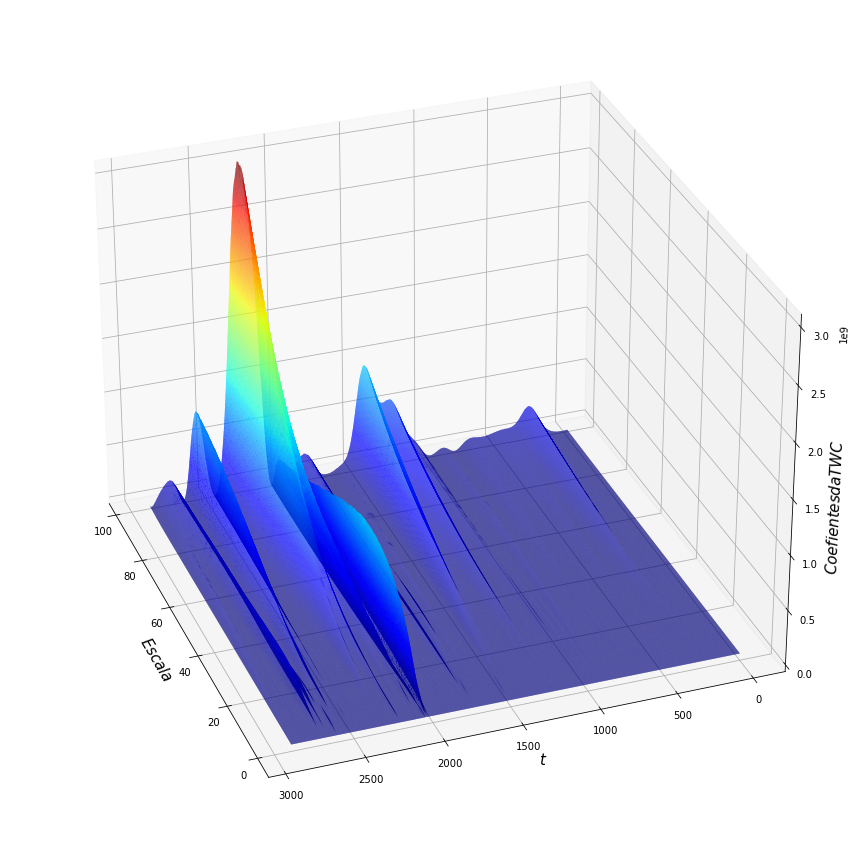

In [92]:
coef_df = pd.DataFrame(coef_)

# Transform it to a long format
df=coef_df.unstack().reset_index()

df.columns=["X","Y","Z"]

# And transform the old column name in something numeric
df['X']=pd.Categorical(df['X'])
df['X']=df['X'].cat.codes

# Make the plot
fig = plt.figure(figsize = (15,16))
ax = fig.add_subplot(projection ='3d')
ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap="jet", linewidth=0.2)
ax.set_xlabel('$Escala$', fontsize=15)
ax.set_ylabel('$t$', fontsize=15)
ax.set_zlabel('$Coefientes da TWC$', fontsize=15, rotation = 0)

# Set the angle of the camera
ax.view_init(30,160) #(30,110)


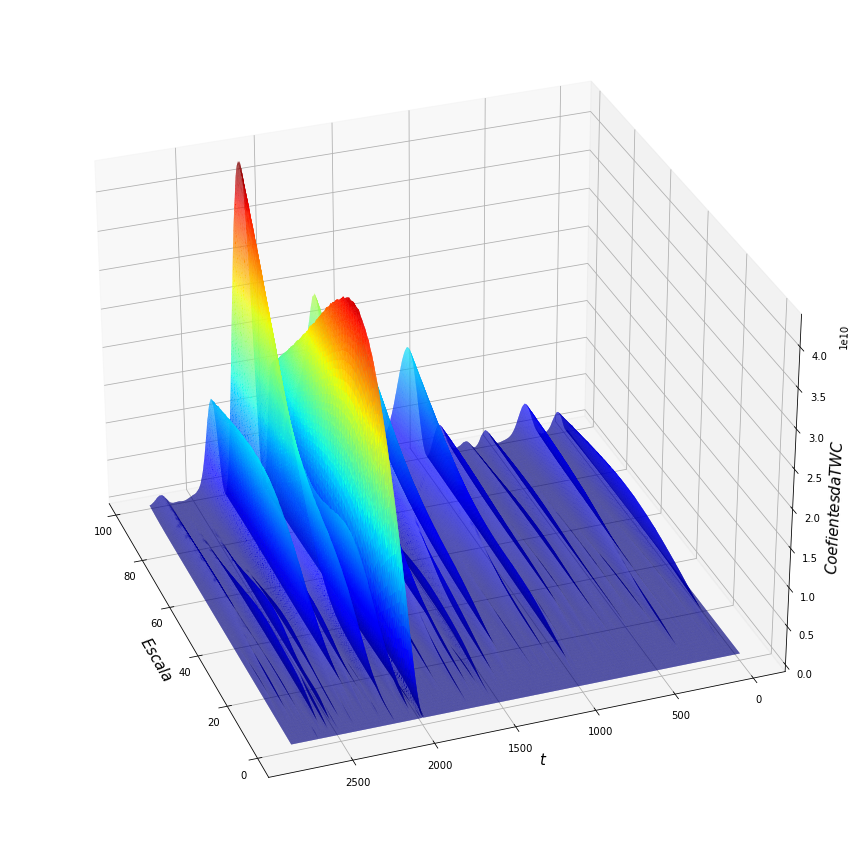

In [93]:
coef_df = pd.DataFrame(coef_W)

# Transform it to a long format
df=coef_df.unstack().reset_index()

df.columns=["X","Y","Z"]

# And transform the old column name in something numeric
df['X']=pd.Categorical(df['X'])
df['X']=df['X'].cat.codes

# Make the plot
fig = plt.figure(figsize = (15,16))
ax = fig.add_subplot(projection ='3d')
ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap="jet", linewidth=0.2)
ax.set_xlabel('$Escala$', fontsize=15)
ax.set_ylabel('$t$', fontsize=15)
ax.set_zlabel('$Coefientes da TWC$', fontsize=15, rotation = 0)

# Set the angle of the camera
ax.view_init(30,160) #(30,110)


## Mapa de coerencia 

In [20]:
serie_d.index

DatetimeIndex(['2012-02-01', '2012-02-02', '2012-02-03', '2012-02-06',
               '2012-02-07', '2012-02-08', '2012-02-09', '2012-02-10',
               '2012-02-13', '2012-02-14',
               ...
               '2023-05-19', '2023-05-22', '2023-05-23', '2023-05-24',
               '2023-05-25', '2023-05-26', '2023-05-29', '2023-05-30',
               '2023-05-31', '2023-06-01'],
              dtype='datetime64[ns]', name='Date', length=2952, freq=None)

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from piwavelet import piwavelet


octave not found, please see README


ImportError: cannot import name 'octave' from 'oct2py' (C:\Users\matheus.mori\AppData\Roaming\Python\Python39\site-packages\oct2py\__init__.py)

In [31]:
y1 = np.random.rand(100) #Generation of the Random Signal 1
y2 = np.random.rand(100) #Generation of the Random Signal 2
x = np.arange(0,100,1) # Time step
y1 = (y1-y1.mean())/y1.std() #Normalization of the Signal 1
y2 = (y2-y2.mean())/y2.std() #Normalization of the Signal 2
myCoherence = piwavelet.wcoherence(y1,y2) #(serie_ibov,serie_d) #Wavelet Coherence Analysis
myCoherence.plot(t = x, title='Test',units='sec') # Plot of the Coherence Map
Rsq,period,scale,coi,sig95=myCoherence() # If you want to know the individual properties.


NameError: name 'piwavelet' is not defined

In [32]:
y1 = np.random.rand(50) #Generation of the Random Signal 1
y2 = np.random.rand(50) #Generation of the Random Signal 2
x = np.arange(0,50,1) # Time step
y1 = (y1-y1.mean())/y1.std() #Normalization of the Signal 1
y2 = (y2-y2.mean())/y2.std() #Normalization of the Signal 2
myXSpec = piwavelet.wcross(y1,y2) #Cross Wavelet Analisys
myXSpec.plot(t = x, title='Test',units='sec') # Plot of the Cross Power Spectrum Map
xwt,period, scale, coi, sig95=myXSpec() # If you want to know the individual properties.'


NameError: name 'piwavelet' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from piwavelet import piwavelet
y1 = np.random.rand(50) #Generation of the Random Signal
y1 = (y1-y1.mean())/y1.std() #Normalization of the Signal 1
wave, scales, freqs, coi, fft, fftfreqs=piwavelet.cwt(y1) # If you want to know the individual properties.'
piwavelet.plotWavelet(y1,title='test',label='Random Signal',units='days')